# About
Notebook exploring the Efficiency comparisons of Standard Deviation vs. Mean Deviation.

This is dealt with in chapter 4 of the technical incerto. For distributions fatter than gaussian, the mean deviation is more precise (less variability in its estimation).

In [1]:
import numpy as np
from numpy.random import default_rng

# Initialise Random Number Generator
rng = default_rng()

### Helper Functions

In [2]:
def mad(x):
    """Calculate Mean Absolute Deviation
    
    The average deviation from sample mean.
    Not to be confused with 'Median' Absolute Deviation.
    Source: https://github.com/FergM/fattails/blob/87fddc034937a6d25f2e62c8aad3d60f1aac1856/fattails/metrics.py#L7
    
    Parameters
    ----------
    x : array_like
        Input array or object that can be converted to an array.
    Returns
    -------
    mad : scalar
          Mean Absolute Deviation of x
    """

    mean = np.mean(x)

    deviation = x-mean

    absolute_deviation = np.abs(deviation)

    mad = np.mean(absolute_deviation)

    return mad

In [3]:
def sample_mixed_norm(jump_sigma, jump_prob, n):
    """ Draw samples from a standard Normal distribution, with occasional spikes in standard deviation.
    
    The standard deviation switches from 1 to jump_sigma with probability p.
    The output returns n samples.

    Parameters
    ----------
    jump_sigma : float
        Standard deviation of our high variance distribution.
    jump_prob : float
        Probability of sampling from the high variance distribution.
    n : int
        The number of output samples.
    
    Returns
    -------
    out : ndarray
        A floating-point array of shape `n` of drawn samples.
        
    Examples
    --------
    >>> sample_mixed_norm(jump_sigma=1, jump_prob=0, n=1)  # No jump probability

    >>> sample_mixed_norm(jump_sigma=3, jump_prob=0.01, n=3)  # Three Sigma Jump for 1% of datapoints.
    """

    # --------------------------------------------
    # Generate Samples from a Standard Normal 
    normals = rng.standard_normal(n)

    # --------------------------------------------
    # Rescale jump_prob % of samples with jump_sigma

    # Flag some samples for rescaling
    jump_flag = rng.binomial(1, jump_prob, n)
    jump_flag = jump_flag.astype(bool)
    norm_flag = ~jump_flag

    # Rescale Flagged Samples to get a Mixed Gaussian
    jump_flag_rvs = normals*jump_flag*jump_sigma
    norm_flag_rvs = normals*norm_flag

    mixed_rvs = jump_flag_rvs + norm_flag_rvs

    return mixed_rvs

In [4]:
def get_efficiency(data):
    """Calculate the "efficiency" of samples in a dataset.
    
    The variance of a dataset normalised by its sample mean.
    Efficient datasets will return a value near 0.
    
    Parameters
    ----------
    data : list-like numeric data
        The values whose efficiency you want to calculate.
    
    """
    
    variance = np.var(data)
    mean = np.mean(data)
    
    # Calculate normalised variance
    # This is equivalent to normalising the dataset
    # so that it has a mean value of 1.
    efficiency = np.var(data)/(np.mean(data))**2
    
    return efficiency
    

In [5]:
# Check Function Executes
sample_mixed_norm(jump_sigma=3, jump_prob=0.01, n=3)

array([-0.46114958,  0.30579549,  1.29543481])

In [6]:
# Check Efficiency Function
get_efficiency([0,10,20])

0.6666666666666667

In [7]:
get_efficiency([0,1,2])

0.6666666666666666

In [8]:
get_efficiency([1,1,1])

0.0

# Analyse
Lets look at what happens when we fatten the distribution away from a standard gaussian.

### First check calibration for Gaussian case

In [9]:
# Settings
n_samples = 100_000     # Number of samples
n_datapoints = 1_000  # Number of datapoints in each sample

# Jump Definition
jump_sigma = 0
jump_prob = 0              # 1% of datapoints have higher std

In [10]:
# Generate Random Samples
samples = [sample_mixed_norm(jump_sigma, jump_prob, n=n_datapoints) for i in range(n_samples)]

In [11]:
# Calculate Metrics
std_samples = [np.std(sample) for sample in samples]
mad_samples = [mad(sample) for sample in samples]

In [12]:
# Calculate Metric Variance (Normalised)
std_efficiency = get_efficiency(std_samples)
mad_efficiency = get_efficiency(mad_samples)

In [13]:
std_efficiency

0.0005013502229411268

In [14]:
mad_efficiency

0.0005730253084100833

In [15]:
efficiency_ratio = std_efficiency/mad_efficiency
efficiency_ratio

0.8749181154531791

As expected the efficiency ratio rounds to ~0.87

# Generalise for a Range of Jump Sizes

In [16]:
def estimate_relative_efficiency(jump_sigma, jump_prob, n_samples, n_datapoints):
    """Estimate the relative efficiency or Std vs MAD.
    
    High values (above 1) indicate that Std varies more than MAD.
    High values therefore indicate where MAD is more efficient.
    """

    # Generate Random Samples
    samples = [sample_mixed_norm(jump_sigma, jump_prob, n=n_datapoints) for i in range(n_samples)]

    # Calculate Metrics on the Random Samples
    std_samples = [np.std(sample) for sample in samples]
    mad_samples = [mad(sample) for sample in samples]

    # Calculate Metric Variance (Normalised)
    std_efficiency = get_efficiency(std_samples)
    mad_efficiency = get_efficiency(mad_samples)

    # Calculate relative efficiency (Std/MAD)
    efficiency_ratio = std_efficiency/mad_efficiency
    
    return efficiency_ratio

In [17]:
# Settings
n_samples = 100_000     # Number of samples
n_datapoints = 1_000  # Number of datapoints in each sample

# Jump Definition
jump_prob = 0.01             # 1% of datapoints have higher std
jump_sigma = 2

In [18]:
# Test Example:
estimate_relative_efficiency(jump_sigma, jump_prob, n_samples, n_datapoints)

0.9584088363032649

### Run for a range of jump sizes

In [19]:
import pandas as pd

In [20]:
# Prepare Jump Sizes
sigmas = [1,2,3,4,5,6,7,8]
sr = pd.Series(sigmas, name='Jump Std')

df = sr.to_frame()
df

,Jump Std
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8


In [21]:
# Calculate Efficiency for each Jump Size
df['Relative Efficiency'] = df['Jump Std'].apply(estimate_relative_efficiency, args=(jump_prob, n_samples, n_datapoints))

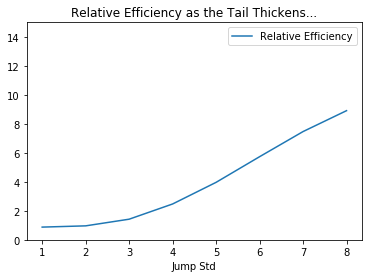

In [22]:
# Plot
df.plot('Jump Std', 'Relative Efficiency', ylim=(0,15), title='Relative Efficiency as the Tail Thickens...')

In [23]:
df.round(2)

,Jump Std,Relative Efficiency
0,1,0.88
1,2,0.96
2,3,1.42
3,4,2.47
4,5,3.96
5,6,5.73
6,7,7.47
7,8,8.91


### Visualise the Performance
Show histograms of sample Std and MAD

##### Case 1: Standard Normal

In [24]:
# Settings
n_samples = 100_000     # Number of samples
n_datapoints = 1_000  # Number of datapoints in each sample

# Jump Definition
jump_prob = 0             # 1% of datapoints have higher std
jump_sigma = 0

In [25]:
# Generate Random Samples
samples = [sample_mixed_norm(jump_sigma, jump_prob, n=n_datapoints) for i in range(n_samples)]

# Calculate Metrics
std_samples = [np.std(sample) for sample in samples]
mad_samples = [mad(sample) for sample in samples]

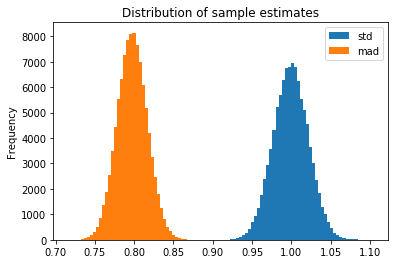

In [26]:
# Plot Sample Distributions
d = {'std': std_samples, 'mad': mad_samples}
df = pd.DataFrame(d)

df.plot(kind='hist', bins=100, title='Distribution of sample estimates');

### Case 2: STD more than twice as wide as MAD
From the line plot above when we ran different jump_probabilities, we can tell that setting `jump_sigma=4` jump makes std/mad efficiency ratio greater than 2.

In [27]:
# Settings
n_samples = 100_000     # Number of samples
n_datapoints = 1_000  # Number of datapoints in each sample

# Jump Definition
jump_prob = 0.1             # 1% of datapoints have higher std
jump_sigma = 4

In [28]:
# Generate Random Samples
samples = [sample_mixed_norm(jump_sigma, jump_prob, n=n_datapoints) for i in range(n_samples)]

# Calculate Metrics
std_samples = [np.std(sample) for sample in samples]
mad_samples = [mad(sample) for sample in samples]

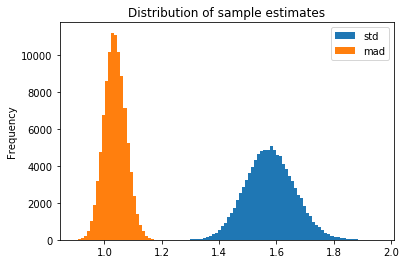

In [29]:
# Plot Sample Distributions
d = {'std': std_samples, 'mad': mad_samples}
df = pd.DataFrame(d)

df.plot(kind='hist', bins=100, title='Distribution of sample estimates');

##### Normalise for Comparison
Normalise the metric magnitudes so we can overlay them for comparison.

In [30]:
std_mean = np.mean(std_samples)
mad_mean = np.mean(mad_samples)

# Generous Method (Think Percentage error)
# The Book uses this method for Relative Efficiency
#std_normalised_samples = std_samples/std_mean
#mad_normalised_samples = mad_samples/mad_mean

# Practical Method (Think error magnitude)
std_normalised_samples = std_samples - std_mean
mad_normalised_samples = mad_samples - mad_mean

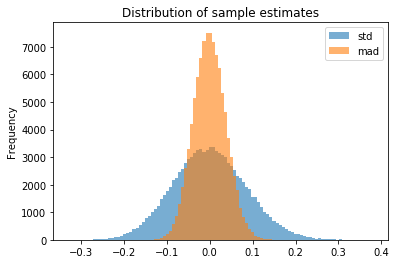

In [31]:
# Plot Sample Distributions
d = {'std': std_normalised_samples, 'mad': mad_normalised_samples}
df = pd.DataFrame(d)

df.plot(kind='hist', bins=100, title='Distribution of sample estimates', alpha=0.6);